In [1]:
import os
import cv2
import shutil
import random
import math
import numpy as np
import tensorflow as tf
from PIL import Image
from imageio.v2 import imread
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array





Primero de todo, podemos empezar contando la cantidad de archivos que tenemos en las carpetas que tenemos, en mi caso, cada clase estaba dentro de una carpeta.

In [4]:
import os
import glob

def contar_png_en_carpeta(carpeta_principal):
    # Diccionario para almacenar los resultados
    resultados = {}
    
    # Recorre todas las subcarpetas de la carpeta principal
    for carpeta in os.listdir(carpeta_principal):
        ruta_carpeta = os.path.join(carpeta_principal, carpeta)
        
        # Verifica si es una carpeta
        if os.path.isdir(ruta_carpeta):
            # Busca todos los archivos .png en la subcarpeta
            archivos_png = glob.glob(os.path.join(ruta_carpeta, '*.JPG'))
            
            # Almacena la cantidad de archivos png en el diccionario
            resultados[carpeta] = len(archivos_png)
    
    return resultados

# Ejemplo de uso
carpeta_principal = 'DATA_Openpose'
resultados = contar_png_en_carpeta(carpeta_principal)

for carpeta, cantidad in resultados.items():
    print(f'Carpeta {carpeta}: {cantidad} archivos PNG')


Carpeta A: 102 archivos PNG
Carpeta B: 76 archivos PNG
Carpeta C: 87 archivos PNG
Carpeta D: 93 archivos PNG
Carpeta E: 103 archivos PNG
Carpeta F: 90 archivos PNG
Carpeta G: 93 archivos PNG
Carpeta I: 84 archivos PNG
Carpeta K: 92 archivos PNG
Carpeta L: 109 archivos PNG
Carpeta M: 0 archivos PNG
Carpeta N: 39 archivos PNG
Carpeta O: 96 archivos PNG
Carpeta P: 89 archivos PNG
Carpeta Q: 92 archivos PNG
Carpeta R: 81 archivos PNG
Carpeta S: 89 archivos PNG
Carpeta T: 78 archivos PNG
Carpeta U: 103 archivos PNG


Para poder trabajar mejor con los archivos, los renombramos y para que en el nombre tengan la información de la clase que pertenecen y los metemos todos a una misa clase

In [6]:


def renombrar_y_mover_png(carpeta_principal, carpeta_destino):
    # Crea la carpeta de destino si no existe
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)
    
    # Recorre todas las subcarpetas de la carpeta principal
    for carpeta in os.listdir(carpeta_principal):
        ruta_carpeta = os.path.join(carpeta_principal, carpeta)
        
        # Verifica si es una carpeta
        if os.path.isdir(ruta_carpeta):
            # Busca todos los archivos .png en la subcarpeta
            archivos_png = [f for f in os.listdir(ruta_carpeta) if f.endswith('.JPG')]
            
            # Renombra y mueve cada archivo .png
            for indice, archivo in enumerate(archivos_png, start=1):
                nuevo_nombre = f"{carpeta}_{indice}.png"
                ruta_archivo_origen = os.path.join(ruta_carpeta, archivo)
                ruta_archivo_destino = os.path.join(carpeta_destino, nuevo_nombre)
                
                # Mueve el archivo a la carpeta de destino con el nuevo nombre
                shutil.move(ruta_archivo_origen, ruta_archivo_destino)
                print(f'Movido: {ruta_archivo_origen} -> {ruta_archivo_destino}')

# Ejemplo de uso
carpeta_principal = 'Data_Openpose'
carpeta_destino = 'Training_archivos'
renombrar_y_mover_png(carpeta_principal, carpeta_destino)


Movido: Data_Openpose\A\openPose_DSC00882.JPG -> Training_archivos\A_1.png
Movido: Data_Openpose\A\openPose_DSC00883.JPG -> Training_archivos\A_2.png
Movido: Data_Openpose\A\openPose_DSC00884.JPG -> Training_archivos\A_3.png
Movido: Data_Openpose\A\openPose_DSC00885.JPG -> Training_archivos\A_4.png
Movido: Data_Openpose\A\openPose_DSC00886.JPG -> Training_archivos\A_5.png
Movido: Data_Openpose\A\openPose_DSC00887.JPG -> Training_archivos\A_6.png
Movido: Data_Openpose\A\openPose_DSC00888.JPG -> Training_archivos\A_7.png
Movido: Data_Openpose\A\openPose_DSC00889.JPG -> Training_archivos\A_8.png
Movido: Data_Openpose\A\openPose_DSC00890.JPG -> Training_archivos\A_9.png
Movido: Data_Openpose\A\openPose_DSC00891.JPG -> Training_archivos\A_10.png
Movido: Data_Openpose\A\openPose_DSC00892.JPG -> Training_archivos\A_11.png
Movido: Data_Openpose\A\openPose_DSC00893.JPG -> Training_archivos\A_12.png
Movido: Data_Openpose\A\openPose_DSC00894.JPG -> Training_archivos\A_13.png
Movido: Data_Openpose

En este apartado de aqui, hay una función que sirve para que muevas el 15% de cada clase a una carpeta nueva, para luego testear con ellos el modelo

In [8]:

def mover_15_por_ciento(carpeta_principal, carpeta_destino, porcentaje=0.15):
    # Crea la carpeta de destino si no existe
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)

    # Busca todos los archivos .png en la carpeta principal
    archivos_png = [f for f in os.listdir(carpeta_principal) if f.endswith('.png')]

    # Calcula el 15% de los archivos
    cantidad_a_mover = math.ceil(len(archivos_png) * porcentaje)

    # Selecciona al azar los archivos a mover
    archivos_a_mover = random.sample(archivos_png, cantidad_a_mover)

    # Mueve cada archivo seleccionado a la carpeta de destino
    for archivo in archivos_a_mover:
        ruta_archivo_origen = os.path.join(carpeta_principal, archivo)
        ruta_archivo_destino = os.path.join(carpeta_destino, archivo)

        # Mueve el archivo a la carpeta de destino
        shutil.move(ruta_archivo_origen, ruta_archivo_destino)
        print(f'Movido: {ruta_archivo_origen} -> {ruta_archivo_destino}')

# Ejemplo de uso
carpeta_principal = 'Training_archivos'
carpeta_destino = 'Testing_archivos'
mover_15_por_ciento(carpeta_principal, carpeta_destino)


Movido: Training_archivos\R_8.png -> Testing_archivos\R_8.png
Movido: Training_archivos\F_9.png -> Testing_archivos\F_9.png
Movido: Training_archivos\O_22.png -> Testing_archivos\O_22.png
Movido: Training_archivos\R_58.png -> Testing_archivos\R_58.png
Movido: Training_archivos\D_47.png -> Testing_archivos\D_47.png
Movido: Training_archivos\Q_89.png -> Testing_archivos\Q_89.png
Movido: Training_archivos\B_46.png -> Testing_archivos\B_46.png
Movido: Training_archivos\O_54.png -> Testing_archivos\O_54.png
Movido: Training_archivos\K_73.png -> Testing_archivos\K_73.png
Movido: Training_archivos\C_18.png -> Testing_archivos\C_18.png
Movido: Training_archivos\S_26.png -> Testing_archivos\S_26.png
Movido: Training_archivos\K_4.png -> Testing_archivos\K_4.png
Movido: Training_archivos\P_36.png -> Testing_archivos\P_36.png
Movido: Training_archivos\Q_82.png -> Testing_archivos\Q_82.png
Movido: Training_archivos\B_5.png -> Testing_archivos\B_5.png
Movido: Training_archivos\L_12.png -> Testing_ar

Esta funcioón de aqui nos servira para poder cargar y preprocesar una imagen, lo cargara, le ajustara el tamaño y normalizara sus valores

In [5]:
# Define las dimensiones de la imagen
img_width, img_height = 224, 224

# Define una función para cargar y preprocesar una imagen
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalizar valores de píxeles
    return img_array


En este apartado de aqui aplicaremos el apartado donde haremos el augmento de data, le aplicaremos rotación y transalción a las imagenes que ya tenemos

In [31]:
# Función para aplicar aumentos de datos a una imagen
def augment_image(image, angle, tx, ty):
    rows, cols = image.shape[:2]

    # Rotación
    M_rot = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M_rot, (cols, rows), borderMode=cv2.BORDER_CONSTANT )

    # Traslación
    M_trans = np.float32([[1, 0, tx], [0, 1, ty]])
    translated_image = cv2.warpAffine(rotated_image, M_trans, (cols, rows), borderMode=cv2.BORDER_CONSTANT )

    return translated_image

# Parámetros de aumentos de datos
angle_range = (-30, 30)  # Rango de ángulos de rotación en grados
translation_range = (-0.2, 0.2)  # Rango de traslación como fracción de la dimensión de la imagen

input_dir = "Training_archivos"
output_dir = "Training_archivos_augmented"
if not os.path.exists(output_dir):
        os.makedirs(output_dir)

# Generar aumentos de datos
for i in range(5):
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.png'):

            file_path = os.path.join(input_dir, file_name)
            A = load_and_preprocess_image(file_path)

            angle = random.uniform(angle_range[0], angle_range[1])
            tx = random.uniform(translation_range[0], translation_range[1])
            ty = random.uniform(translation_range[0], translation_range[1])

            A = (A * 255).astype(np.uint8)
            augmented_frame = augment_image(A, angle, tx * A.shape[1], ty * A.shape[0])
            
            # flipped = tf.image.flip_left_right(frame_array)
            # flipped = flipped.numpy() 
            new_filename = f"{file_name}_{i+1}.png"

            # Guardar la imagen aumentada en el directorio de salida
            output_path = os.path.join(output_dir, new_filename)
            cv2.imwrite(output_path, augmented_frame)

print("Data augmentation completed.")


Data augmentation completed.


En esta de aqui, empezaremos preparando nuestros datos, guardareos los valores de cada imagen junto a su etiqueta. Esa etiqueta la codificaremos con one-hot.

In [46]:
# Define la ruta al directorio de datos
data_dir = 'Training_archivos'

# Crea un diccionario para almacenar los datos y etiquetas
data = {}
y = []
x = []
# Itera sobre los archivos en el directorio de datos
for file_name in os.listdir(data_dir):
    if file_name.endswith('.png'):
        # Extrae información del nombre del archivo
        parts = file_name.split('_')
        clase = parts[0]
        file_path = os.path.join(data_dir, file_name)
        A = load_and_preprocess_image(file_path)
        x.append(A)
        y.append(clase)


x = np.array(x)
y = np.array(y)

        
#num_classes = len(y)
label_encoder = LabelEncoder()
etiquetas_codificadas = label_encoder.fit_transform(y)


y = to_categorical(etiquetas_codificadas)


num_classes = len(y[1])



1356 1356
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',

Aqui ya cremaos, nuestro modelo cnn, para ello, dividimos los archivos de entrenamiento en entrenamiento y validación y lo evaluaremos basandonos en el grafico de aciertos y en el grafico de perdida.

(1356, 18)
18


c:\Users\garme\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 34s 878ms/step - accuracy: 0.3405 - loss: 2.2870 - val_accuracy: 0.6127 - val_loss: 1.2742
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8033 - loss: 0.7198 - val_accuracy: 0.7206 - val_loss: 0.9852
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9630 - loss: 0.1763 - val_accuracy: 0.7255 - val_loss: 1.2936
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9857 - loss: 0.0536 - val_accuracy: 0.7402 - val_loss: 1.8090
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9919 - loss: 0.0258 - val_accuracy: 0.7304 - val_loss: 1.6194
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9930 - loss: 0.0296 - val_accuracy: 0.7892 - val_loss: 1.6122
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9986 - loss: 0.0023 - val_accuracy: 0.7892 - val_loss: 1.7610
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9986 - loss: 0.0023 - val_accuracy: 0.7794 - val_lo

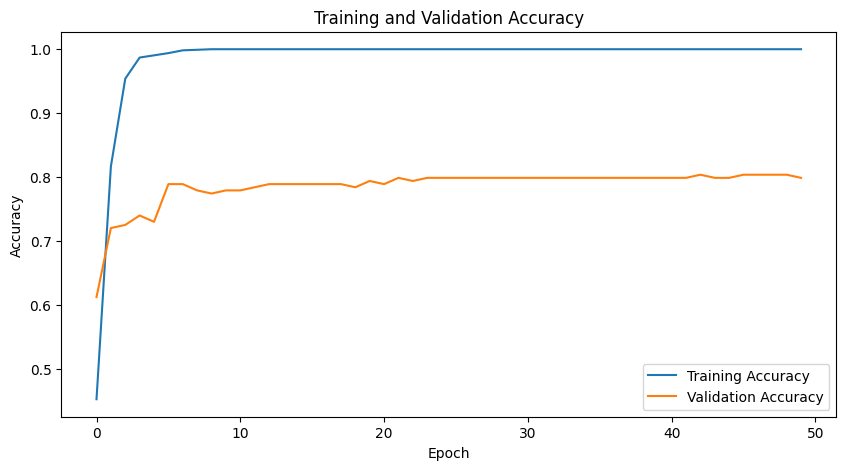

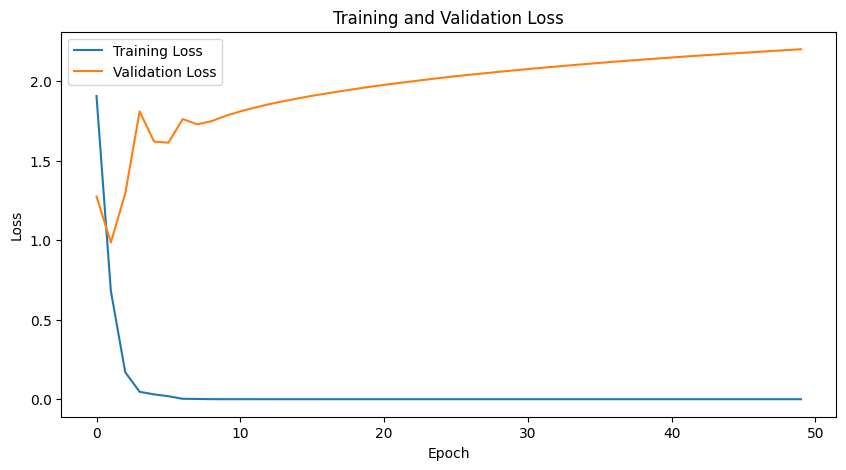

In [51]:

def create_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)



model = create_model(num_classes)

# Entrenar el modelo y guardar el historial
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


# Graficar los resultados
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


En esta de aqui, entrenaremos otro modelo, utilizando un modelo preentrenado, en este caso el VGG16

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 419s 11s/step - accuracy: 0.1330 - loss: 3.4862 - val_accuracy: 0.3284 - val_loss: 2.4042
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 307s 9s/step - accuracy: 0.4263 - loss: 2.1058 - val_accuracy: 0.4167 - val_loss: 1.9874
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 257s 7s/step - accuracy: 0.5729 - loss: 1.6137 - val_accuracy: 0.5441 - val_loss: 1.5903
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 292s 8s/step - accuracy: 0.6643 - loss: 1.2668 - val_accuracy: 0.6961 - val_loss: 1.2268
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 238s 7s/step - accuracy: 0.7808 - loss: 0.9547 - val_accuracy: 0.7108 - val_loss: 0.9632
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 262s 7s/step - accuracy: 0.8418 - loss: 0.7258 - val_accuracy: 0.7549 - val_loss: 0.8472
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 269s 7s/step - accuracy: 0.8970 - loss: 0.5414 - val_accuracy: 0.8088 - val_loss: 0.6975
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 473s 13s/step - accuracy: 0.8998 - loss: 0.4541 - val_accuracy: 0.8186 -

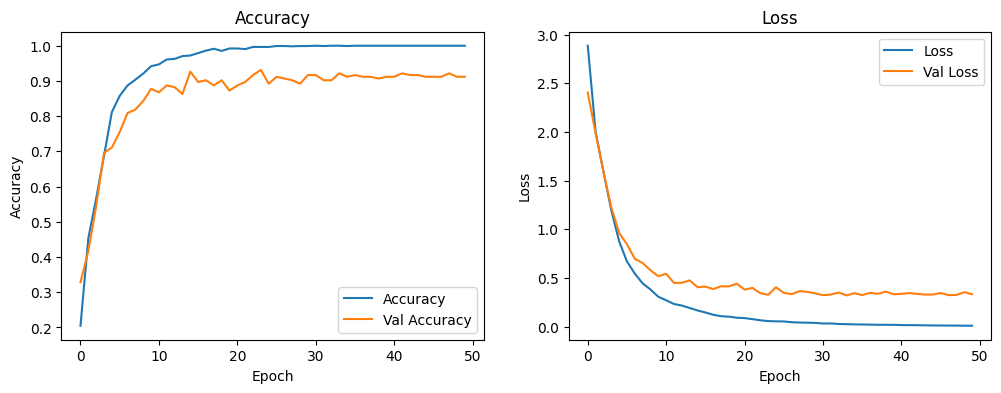

In [24]:
# Cargar el modelo preentrenado VGG16 sin las capas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo preentrenado
for layer in base_model.layers:
    layer.trainable = False

# Crear la nueva arquitectura del modelo
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Supongamos que tus datos ya están cargados en X e y
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Graficar los resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()



Este sera el mismo apartado que el anterior, lo único que cambia es que en este caso el modelo preentrenado sera DenseNet, en caso de querer usar cualquier otro modelo prentrenado, solamente hara falta cambiar el 'base_model' de este apartado.

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.3215 - loss: 8.3094 - val_accuracy: 0.7353 - val_loss: 0.9801
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8597 - loss: 0.4567 - val_accuracy: 0.8578 - val_loss: 0.6168
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9576 - loss: 0.1374 - val_accuracy: 0.8971 - val_loss: 0.4491
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9803 - loss: 0.0686 - val_accuracy: 0.8529 - val_loss: 0.5789
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9919 - loss: 0.0403 - val_accuracy: 0.8824 - val_loss: 0.3875
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9959 - loss: 0.0271 - val_accuracy: 0.8627 - val_loss: 0.4854
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 0.8775 - val_loss: 0.3701
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.9069 - val_l

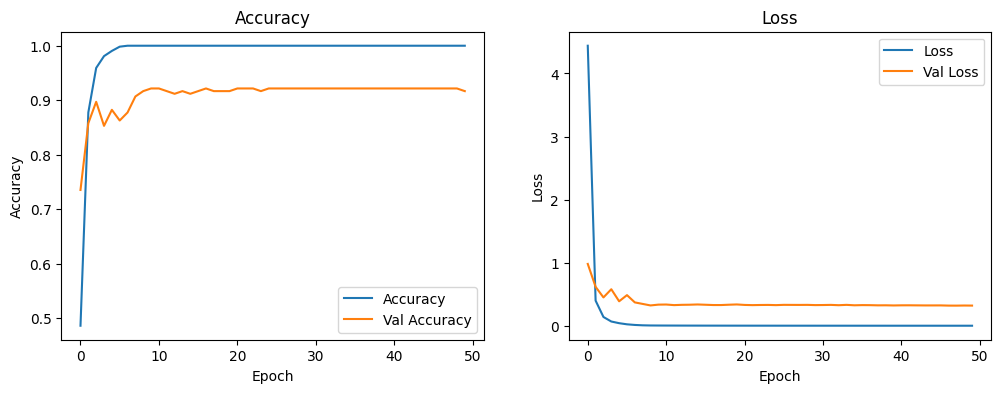

In [47]:

# Cargar el modelo preentrenado DenseNet sin las capas superiores
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo preentrenado
for layer in base_model.layers:
    layer.trainable = False

# Crear la nueva arquitectura del modelo
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Dividir los datos en conjuntos de entrenamiento y validación (85%-15%)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

# Entrenar el modelo y guardar el historial
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Graficar los resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()


Está de aqui tambien es lo mismo pero con MobileNetV2, he decidio dejarlos todos, para que se puedan ver las diferencias desde aqui.

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 588ms/step - accuracy: 0.3220 - loss: 12.1959 - val_accuracy: 0.6618 - val_loss: 1.1423
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 618ms/step - accuracy: 0.7734 - loss: 0.7843 - val_accuracy: 0.8529 - val_loss: 0.6291
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 597ms/step - accuracy: 0.9110 - loss: 0.3014 - val_accuracy: 0.8824 - val_loss: 0.4805
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 678ms/step - accuracy: 0.9759 - loss: 0.1162 - val_accuracy: 0.8725 - val_loss: 0.5938
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 682ms/step - accuracy: 0.9840 - loss: 0.0663 - val_accuracy: 0.8922 - val_loss: 0.5170
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 673ms/step - accuracy: 0.9946 - loss: 0.0266 - val_accuracy: 0.8873 - val_loss: 0.4905
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 674ms/step - accuracy: 0.9977 - loss: 0.0161 - val_accuracy: 0.9265 - val_loss: 0.4290
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 671ms/step - accuracy: 0.9999 - loss: 0.0064 - val_acc

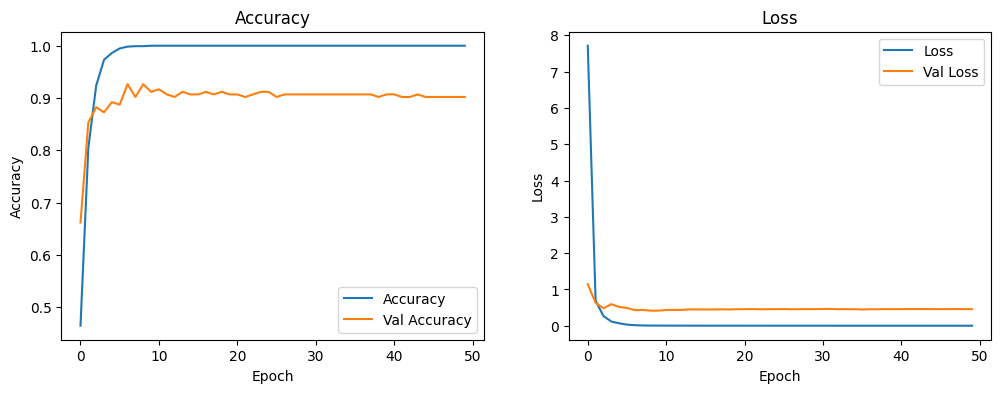

In [41]:
# Cargar el modelo preentrenado MobileNetV2 sin las capas superiores
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo preentrenado
for layer in base_model.layers:
    layer.trainable = False

# Crear la nueva arquitectura del modelo
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Dividir los datos en conjuntos de entrenamiento y validación (85%-15%)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

# Entrenar el modelo y guardar el historial
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Graficar los resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()


En este apartado de aqui, se cargan los archivos guardados que teniamos en la carpeta para testear, y se evalua el modelo que anteriormente a sido ejecutado.

In [50]:
# Define la ruta al directorio de test
test_dir = 'Testing_archivos'

# Crea un diccionario para almacenar los datos de test

x_test = []
y_test = []
# Itera sobre los archivos en el directorio de test
for file_name in os.listdir(test_dir):
    if file_name.endswith('.png'):
        # Extrae información del nombre del archivo
        parts = file_name.split('_')
        clase = parts[0]
        
        file_path = os.path.join(test_dir, file_name)
        A = load_and_preprocess_image(file_path)

        x_test.append(A)
        y_test.append(clase)
        
x_test = np.array(x_test)
y_test = np.array(y_test)

num_classes = len(y_test)
label_encoder = LabelEncoder()
etiquetas_codificadas = label_encoder.fit_transform(y_test)

y_test = to_categorical(etiquetas_codificadas)
print(y_test.shape)

# Evaluar el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

(240, 18)
Test loss: 0.3224, Test accuracy: 0.9333


En este último apartado tenemos la matriz de confusion

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step


<Figure size 1000x1000 with 0 Axes>

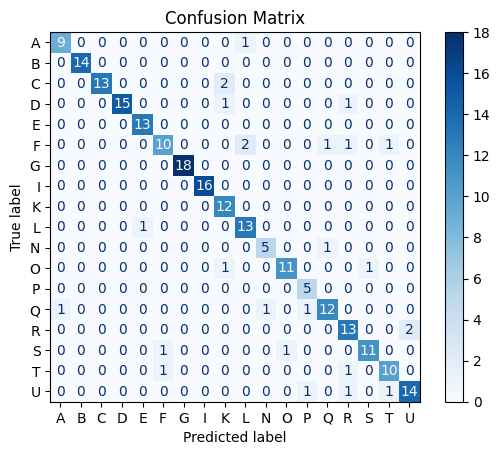

In [44]:
# Obtener las predicciones del modelo
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generar la matriz de confusión
cm = confusion_matrix(etiquetas_codificadas, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()